# Carregando as bibliotecas necessárias

In [14]:
from flask import Flask, request, jsonify, render_template
import tensorflow as tf
import numpy as np
import cv2
from sklearn.pipeline import Pipeline
import os
from modules.preprocess import Resize, GaussianBlur, CLAHE_Color, Normalize, show_images_in_notebook
from modules.heatmap import saliency_map, visualize_saliency
import base64
from io import BytesIO
from tensorflow import keras
from IPython.display import display
from PIL import Image
import io

from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode



# Carregando a câmera e tirando foto

<IPython.core.display.Javascript object>

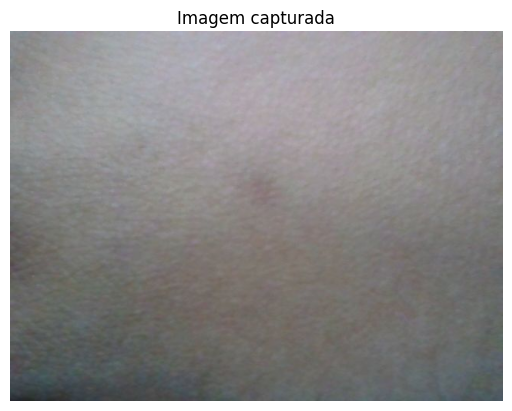

In [6]:
from IPython.display import Javascript, display
from google.colab.output import eval_js
from base64 import b64decode
import cv2
import numpy as np
import matplotlib.pyplot as plt

def take_photo_cv2(quality=0.8):
    js = Javascript('''
      async function takePhoto(quality) {
        const div = document.createElement('div');
        const capture = document.createElement('button');
        capture.textContent = 'Capture';
        div.appendChild(capture);

        const video = document.createElement('video');
        video.style.display = 'block';
        const stream = await navigator.mediaDevices.getUserMedia({video: true});

        document.body.appendChild(div);
        div.appendChild(video);
        video.srcObject = stream;
        await video.play();

        google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
        await new Promise((resolve) => capture.onclick = resolve);

        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        stream.getVideoTracks()[0].stop();
        div.remove();
        return canvas.toDataURL('image/jpeg', quality);
      }
    ''')

    display(js)
    data = eval_js(f'takePhoto({quality})')
    binary = b64decode(data.split(',')[1])
    np_arr = np.frombuffer(binary, dtype=np.uint8)
    img_bgr = cv2.imdecode(np_arr, cv2.IMREAD_COLOR)  # formato BGR
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    return img_rgb

# Tirar a foto e mostrar
try:
    img = take_photo_cv2()
    plt.imshow(img)
    plt.axis('off')
    plt.title("Imagem capturada")
    plt.show()
except Exception as err:
    print("Erro ao capturar imagem:", str(err))


# Pré-processando imagem capturada

In [3]:
model = keras.models.load_model('/content/skin_cancer.keras')

In [4]:
preprocess_pipeline = Pipeline([
    ('resize', Resize((128, 128))),
    ('blur', GaussianBlur()),
    ('clahe', CLAHE_Color())
])

def preprocess_and_load_image(img):
    try:
        processed_img = preprocess_pipeline.transform([img])[0]
        return img, processed_img
    except Exception as e:
        print(f"Erro ao pré-processar/carregar imagem: {e}")
        return None, None

In [24]:
processed_img = preprocess_pipeline.transform([img])[0]

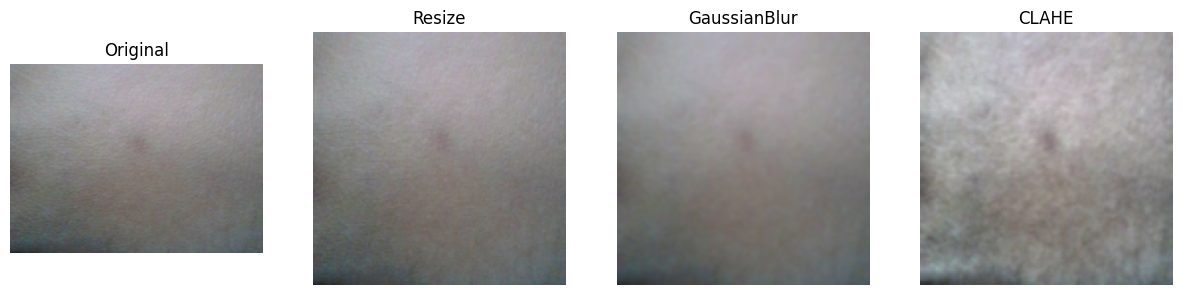

In [7]:
step1 = Resize((128, 128)).fit_transform([img])
step2 = GaussianBlur((3, 3)).fit_transform(step1)
step3 = CLAHE_Color().fit_transform(step2)

show_images_in_notebook([img, step1[0], step2[0], step3[0]],
            titles=["Original", "Resize", "GaussianBlur", "CLAHE"])

In [9]:
original_image, processed_image = preprocess_and_load_image(img)

prediction = model.predict(np.expand_dims(processed_image, axis=0))
probability = prediction[0][0]
class_label = "maligno" if probability > 0.5 else "benigno"

# Gerar o mapa de saliência
saliency = saliency_map(model, processed_image)

# Visualizar o mapa de saliência sobre a imagem original
saliency_overlayed = visualize_saliency(original_image, saliency)

# Codificar a imagem com o mapa de saliência para base64
_, img_encoded = cv2.imencode('.jpg', saliency_overlayed)

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


# Apresentando resultados

In [12]:
print(f"Probabilidade de ser maligno de {probability*100:.2f}%")

Probabilidade de ser maligno de 52.61%


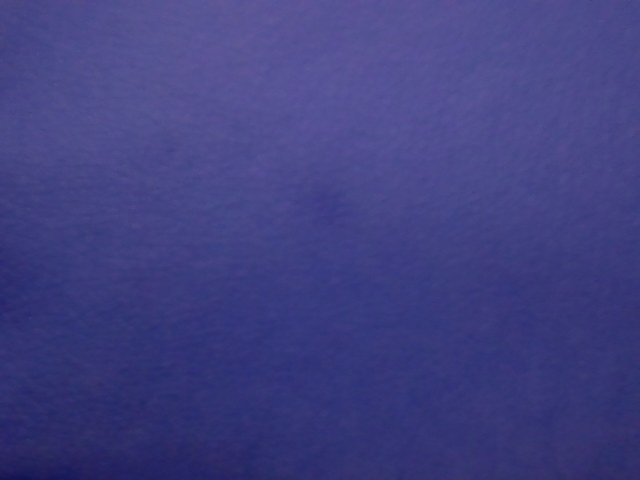

In [15]:
# Converte o array codificado em bytes para imagem
image = Image.open(io.BytesIO(img_encoded.tobytes()))

# Exibe no notebook
display(image)